## Network Intrusions Clustering


### 4.1. Uploading Data

In [ ]:
%%capture
!wget https://www.dropbox.com/s/xi3gj1nygdmseys/clustering_data.zip
!unzip clustering_data.zip

### 4.2. Libraries Installation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 4.3. Read Data and Data exploration


In [ ]:
trainset = pd.read_csv('trainset.csv')
testset = pd.read_csv('testset.csv')
trainset

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0
175337,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0
175338,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0
175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0


### 4.4. Categorical Features
- Check categorical features
- One-hot-encoding of categorical feature

In [ ]:
types = trainset.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 3
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_

In [ ]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

print(f'before encoding: trainset size {trainset.shape} and testset size {testset.shape}')

def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    new_cols = pd.DataFrame(new_feats, dtype=int)
    new_df = pd.concat([df, new_cols], axis=1)
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)#Data is considered sparse when certain expected values in a dataset are missing
cat_feats = ['proto', 'service', 'state']
encoder.fit(trainset[cat_feats])
trainset = ohe_new_features(trainset, cat_feats, encoder)
testset = ohe_new_features(testset, cat_feats, encoder)
print(f'after encoding: trainset size {trainset.shape} and testset size {testset.shape}')

before encoding: trainset size (175341, 42) and testset size (82332, 42)
after encoding: trainset size (175341, 194) and testset size (82332, 194)


### 4.5. Data Imputation
There is no need for imputation as there are no missing values as shown below.

In [ ]:
def count_nans(df):
    return np.sum(np.sum(np.isnan(df)))

print(f'Number of missing values in trainset, testset: {count_nans(trainset.shape)} , {count_nans(testset.shape)} \nthere is no need for imputation')

Number of missing values in trainset, testset: 0 , 0 
there is no need for imputation


### 4.6. Feature Scaling
- Data normalization using Min-Max Scaling 
  
- Min-Max scaling: transform all features to fall in this range: [0, 1].
</span><br>
$$x_i = \frac{x_i - min(\mathbf{x})}{max(\mathbf{x}) - min(\mathbf{x})}$$


In [ ]:
trainset = trainset.to_numpy()
testset = testset.to_numpy()
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
scaler.fit(trainset)
trainset = scaler.transform(trainset)
testset = scaler.transform(testset)

### 4.7. Dimensions Reduction by Principal Component Analysis (PCA)
Data size is very large and it is high dimensionally data. So, PCA is implemented. 

In this section, the following points are implemented.
- Define the number of dimensions : Why reducing dimensions into 3 prinicipal components ?
- Apply PCA


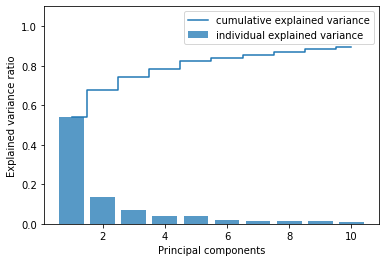


 Why reducing dimensions into 3 prinicipal components ?

- There are 194 principal components, the first 10 only are plotted for visualization.
- The data captured by the first 3 principal components contain 67.46%, about 32.54% of data is lost.
- To capture around 85% of the data, 8 principal components should be considered.
- It is not possible to visualize a data in 8-dimensions, that is why only 3 PC are selected.


In [ ]:
cov_mat = np.cov(trainset.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
# var_exp ratio is fraction of eigen_val to total sum
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# calculate the cumulative sum of explained variances
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 11), var_exp[0:10], alpha=0.75, align='center', label='individual explained variance')
plt.step(range(1, 11), cum_var_exp[0:10], where='mid', label='cumulative explained variance')
plt.ylim(0, 1.1)
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.show()

print(f'\n\033[1m Why reducing dimensions into 3 prinicipal components ?\033[0;0m\n')
print(f'- There are {len(var_exp)} principal components, the first 10 only are plotted for visualization.')
print(f'- The data captured by the first 3 principal components contain {sum(var_exp[0:2])*100:0.2f}%, about {(1-sum(var_exp[0:2]))*100:0.2f}% of data is lost.')
print(f'- To capture around 85% of the data, 8 principal components should be considered.')
print(f'- It is not possible to visualize a data in 8-dimensions, that is why only 3 PC are selected.')

Before PCA : trainset size (175341, 194) and testset size (82332, 194)
After PCA : trainset_reduced size (175341, 3) and testset_reduced size (82332, 3)


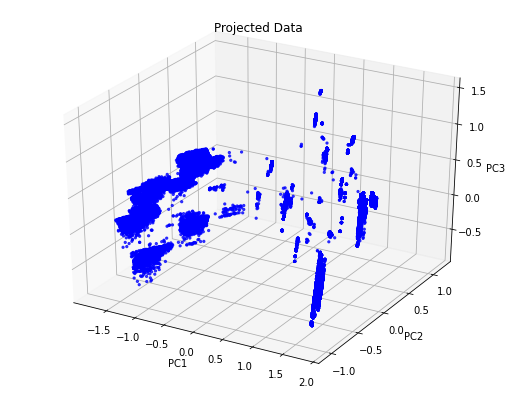

In [ ]:
from sklearn.decomposition import PCA
dim_reducer = PCA(n_components=3)
trainset_reduced = dim_reducer.fit_transform(trainset)
testset_reduced = dim_reducer.fit_transform(testset)
print(f'Before PCA : trainset size {trainset.shape} and testset size {testset.shape}')
print(f'After PCA : trainset_reduced size {trainset_reduced.shape} and testset_reduced size {testset_reduced.shape}')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainset_reduced[:, 0], trainset_reduced[:, 1], trainset_reduced[:, 2], marker='.', alpha=0.75, c='blue')
ax.set_title("Projected Data", fontsize='large')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### 4.8. Choosing k 
In this section:
- Elbow method is used to select k.
- Silhouette score is applied to check the optimum k corresponds to the highest score. 
- Silhouette code is commented because it takes **50 min** to be executed but a screenshot is attached in section (4.9.)

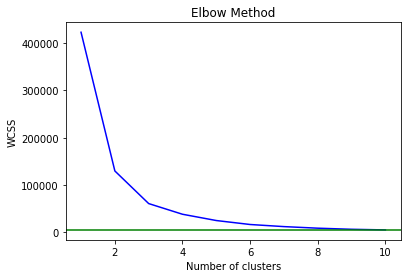

Min WCSS : 5423.74501684043


In [ ]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(trainset_reduced)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, color="blue")
plt.axhline(y=wcss[-1], color='g', linestyle='-', label="Kstab")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.ylim([0, 120000])
plt.show()
print(f'Min WCSS : {wcss[-1]}')

In [ ]:
# from sklearn.metrics import silhouette_score

# silhouettes = []
# k = [i for i in range(5,11)]
# for i in k:
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42).fit(trainset_reduced)
#     y = kmeans.predict(trainset_reduced)
#     score = silhouette_score(trainset_reduced, y, metric='euclidean')
#     silhouettes.append(score)

# plt.plot(range(5, 11), silhouettes)
# plt.title('silhouette Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('silhouette score')
# plt.show()

# max_y = max(silhouettes)  
# max_x = k[silhouettes.index(max_y)]
# print(f'\n\033[1m Maximum silhouette score {max_y} corresponds to {max_x} clusters\033[0;0m\n')

### 4.9. Kmean++ Implementation 
- Different values are obtained for k from elbow and silhouette methods.
- Elbow method shows that there only about 4 clusters, however, there might be an overlapping existed. 
- Because of the overlapping that may be existed in elbow method, silhouette method is applied for verification.
- Silhouette score shows 10 clusters and this confirms the overlapping presented by elbow method. 
- As shown from the graph, the maximum sihouette score is **0.77** corresponds to **10** clusters.
- Kmeans++ techniques is applied and data is visualized.
- Distribution of trainset to the 10 clusters is presented after kmeans++ implementation.
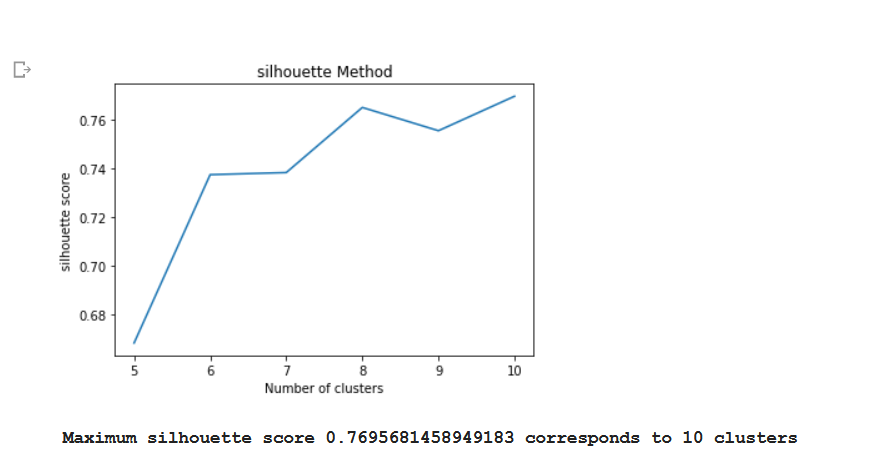

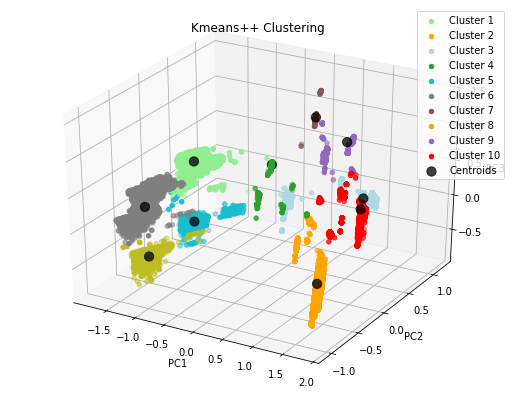

In [ ]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_km = km.fit_predict(trainset_reduced)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainset_reduced[y_km==0, 0], trainset_reduced[y_km==0, 1], trainset_reduced[y_km==0, 2],c='lightgreen', label='Cluster 1')
ax.scatter(trainset_reduced[y_km==1, 0], trainset_reduced[y_km==1, 1], trainset_reduced[y_km==1, 2],c='orange', label='Cluster 2')
ax.scatter(trainset_reduced[y_km==2, 0], trainset_reduced[y_km==2, 1], trainset_reduced[y_km==2, 2],c='lightblue', label='Cluster 3')
ax.scatter(trainset_reduced[y_km==3, 0], trainset_reduced[y_km==3, 1], trainset_reduced[y_km==3, 2],c='#2ca02c', label='Cluster 4')
ax.scatter(trainset_reduced[y_km==4, 0], trainset_reduced[y_km==4, 1], trainset_reduced[y_km==4, 2],c='#17becf', label='Cluster 5')
ax.scatter(trainset_reduced[y_km==5, 0], trainset_reduced[y_km==5, 1], trainset_reduced[y_km==5, 2],c='#7f7f7f', label='Cluster 6')
ax.scatter(trainset_reduced[y_km==6, 0], trainset_reduced[y_km==6, 1], trainset_reduced[y_km==6, 2],c='#8c564b', label='Cluster 7')
ax.scatter(trainset_reduced[y_km==7, 0], trainset_reduced[y_km==7, 1], trainset_reduced[y_km==7, 2],c='#bcbd22', label='Cluster 8')
ax.scatter(trainset_reduced[y_km==8, 0], trainset_reduced[y_km==8, 1], trainset_reduced[y_km==8, 2],c='#9467bd', label='Cluster 9')
ax.scatter(trainset_reduced[y_km==9, 0], trainset_reduced[y_km==9, 1], trainset_reduced[y_km==9, 2],c='red', label='Cluster 10')
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], km.cluster_centers_[:,2], s=85, alpha=0.75, marker='o', c='black', label='Centroids')
ax.set_title("Kmeans++ Clustering", fontsize='large')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [ ]:
n_clusters = 10
clusters = []
for i in range(n_clusters):
  clusters.append(trainset_reduced[y_km==i])
  print(f'cluster {i+1} has {len(clusters[i])} data points')

cluster 1 has 20723 data points
cluster 2 has 39634 data points
cluster 3 has 29197 data points
cluster 4 has 7650 data points
cluster 5 has 24629 data points
cluster 6 has 25264 data points
cluster 7 has 3616 data points
cluster 8 has 8474 data points
cluster 9 has 3892 data points
cluster 10 has 12262 data points


### 4.10. Testset Clustering based on Kmeans++ model
- In this section, testset clusters -based on kmeans++ model- are visualized and distributed.

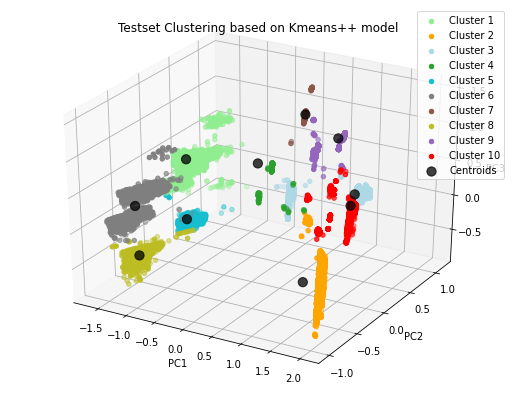


 Testset Distribution:

 - 12058 data points have been identified as cluster 1
 - 18266 data points have been identified as cluster 2
 - 10268 data points have been identified as cluster 3
 - 3097 data points have been identified as cluster 4
 - 15628 data points have been identified as cluster 5
 - 10460 data points have been identified as cluster 6
 - 1587 data points have been identified as cluster 7
 - 3293 data points have been identified as cluster 8
 - 1260 data points have been identified as cluster 9
 - 6415 data points have been identified as cluster 10


In [ ]:
pred = km.predict(testset_reduced)
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(testset_reduced[pred==0, 0], testset_reduced[pred==0, 1], testset_reduced[pred==0, 2],c='lightgreen', label='Cluster 1')
ax.scatter(testset_reduced[pred==1, 0], testset_reduced[pred==1, 1], testset_reduced[pred==1, 2],c='orange', label='Cluster 2')
ax.scatter(testset_reduced[pred==2, 0], testset_reduced[pred==2, 1], testset_reduced[pred==2, 2],c='lightblue', label='Cluster 3')
ax.scatter(testset_reduced[pred==3, 0], testset_reduced[pred==3, 1], testset_reduced[pred==3, 2],c='#2ca02c', label='Cluster 4')
ax.scatter(testset_reduced[pred==4, 0], testset_reduced[pred==4, 1], testset_reduced[pred==4, 2],c='#17becf', label='Cluster 5')
ax.scatter(testset_reduced[pred==5, 0], testset_reduced[pred==5, 1], testset_reduced[pred==5, 2],c='#7f7f7f', label='Cluster 6')
ax.scatter(trainset_reduced[y_km==6, 0], trainset_reduced[y_km==6, 1], trainset_reduced[y_km==6, 2],c='#8c564b', label='Cluster 7')
ax.scatter(trainset_reduced[y_km==7, 0], trainset_reduced[y_km==7, 1], trainset_reduced[y_km==7, 2],c='#bcbd22', label='Cluster 8')
ax.scatter(trainset_reduced[y_km==8, 0], trainset_reduced[y_km==8, 1], trainset_reduced[y_km==8, 2],c='#9467bd', label='Cluster 9')
ax.scatter(trainset_reduced[y_km==9, 0], trainset_reduced[y_km==9, 1], trainset_reduced[y_km==9, 2],c='red', label='Cluster 10')
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], km.cluster_centers_[:,2], s=85, alpha=0.75, marker='o', c='black', label='Centroids')
ax.set_title("Testset Clustering based on Kmeans++ model", fontsize='large')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

print(f'\n\033[1m Testset Distribution:\033[0;0m\n')

for i in range(n_clusters):
  print(f' - {len(testset_reduced[pred==i])} data points have been identified as cluster {i+1}')

### 4.11. Why Kmeans++ not DBSCAN ? 

In fact, Kmeans++ provided a better result than DBSCAN.

Below, DBSCAN is implemented and for 0.06 radius and min number of points inside each circle is 15, data is clustered into 41 clusters !

Tunning of these 2 parameters is not the best option in terms of time complexity, and many attempts have been tried, but ram crashes. 

On other hand, Kmeans++ clustering provided a satisfying results as presented above. 

Number of centroids : 41


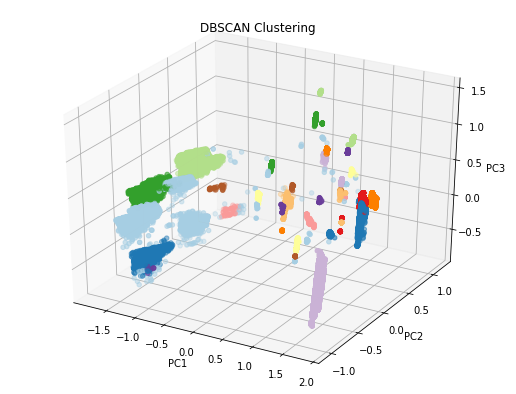

In [ ]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.06, min_samples=15)
y_dbs = dbs.fit_predict(trainset_reduced)
print(f'Number of centroids : {len(set(dbs.labels_))}') #len(set(y_dbs))
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainset_reduced[:,0], trainset_reduced[:,1], trainset_reduced[:,2], c=y_dbs, cmap='Paired')
ax.set_title("DBSCAN Clustering", fontsize='large')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### 4.12. References

https://gmaclenn.github.io/articles/airport-pca-analysis/